<a href="https://colab.research.google.com/github/milad-s5/DL_HW3_RNN/blob/2/2_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas
import math
import scipy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Def functions

In [ ]:
def ocilator_gen(functype, cycles, period, phase, resolution, plot=True):
    """
    Generates an oscillating function
    Parameters
    ----------
    functype: str
        String which determines type of ocilator to use
    cycles: int
        Number of cycles for the total run
    period: float
        Period between peaks in seconds
    phase: float
        Additional phase to add in pi, i.e. 1
    resolution: float
        Maximum time resolution of the data in data points per second
    """

    t = np.linspace(0, cycles * period, resolution)
    phase = phase * np.pi
    internal = 2 * np.pi / period * t + phase

    if functype in ['sin', 'Sin']:
        ocil = np.sin(internal)
    elif functype in ['tri']:
        ocil = signal.sawtooth(internal, 0.5)
    elif functype in ['saw']:
        ocil = signal.sawtooth(internal)
    if plot==True:
      plt.plot(t, ocil)
      plt.xlabel('t')
      plt.ylabel(functype)
      plt.title(functype)
      plt.show()
    return t, ocil

In [ ]:
def snr_f(segment, noise, f_samp, f_max=2048):

    N = len(segment)        # number of points in time series
    T = 1.0 / f_samp        # sample spacing
    x_f = np.fft.fftfreq(N, T)                        
    frequencies = x_f[0:N//2]     # only positive frequencies
    h = segment-noise       # signal, obtained removing noise from segment

    segment_f = scipy.fftpack.fft(segment)[0:N//2]   # segment fft only positive f
    noise_f = scipy.fftpack.fft(noise)[0:N//2]       # noise fft
    h_f = scipy.fftpack.fft(h)[0:N//2]               # signal fft

    h_f =  h_f[np.where(frequencies<=f_max)]            # if an upper cut on frequency is desired
    noise_f = noise_f[np.where(frequencies<=f_max)]                       
    Norm = np.array(np.where(frequencies<=f_max)).shape[1]

    snr_sq = np.sum(abs(h_f)**2/abs(noise_f)**2)     # SNR^2 as sum of ratio of squared fft coeff.
    snr_f = math.sqrt(snr_sq)

    return snr_f

In [ ]:
def plot_signal(t,y,functype):
  plt.plot(t, y)
  plt.xlabel('t')
  plt.ylabel(functype)
  plt.title(functype)
  plt.show()

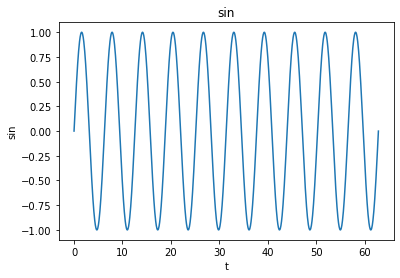

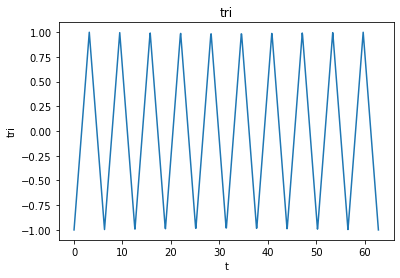

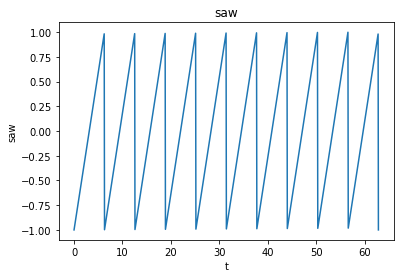

In [ ]:
samples = 1000
_, _ = ocilator_gen('sin', 10, 2*np.pi, 0, samples, True)
_, _ = ocilator_gen('tri', 10, 2*np.pi, 0, samples, True)
_, _ = ocilator_gen('saw', 10, 2*np.pi, 0, samples, True)

# Simple RNN

## sin

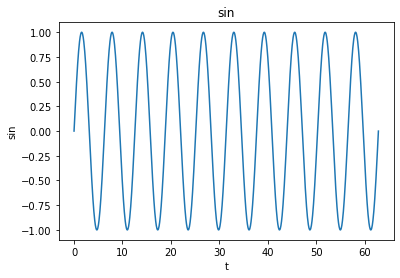

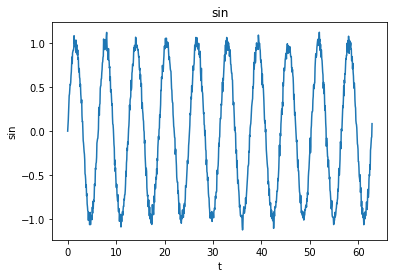

In [ ]:
# add noise
samples = 1000
functype = 'sin'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0065 - val_loss: 0.0012 - 2s/epoch - 4ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0014 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0014 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0015 - val_loss: 0.0012 - 1s/epoch - 2ms/step



test loss = 0.0014183830935508013


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0817
valid MSE: 0.0769
test MSE: 0.0848


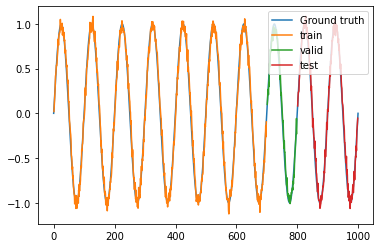

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 225.32192098165478


## tri

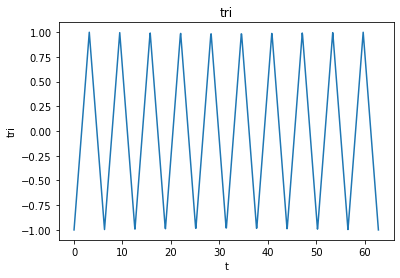

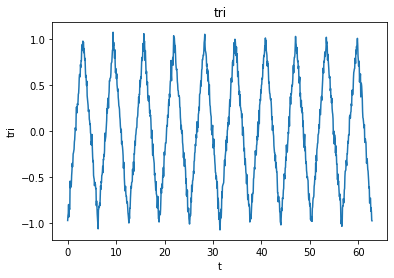

In [ ]:
# add noise
samples = 1000
functype = 'tri'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0954 - val_loss: 0.0130 - 2s/epoch - 3ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0049 - val_loss: 0.0019 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step



test loss = 0.0014501232653856277


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0849
valid MSE: 0.0867
test MSE: 0.0817


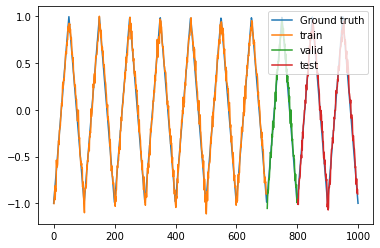

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 317.08057009240486


## saw

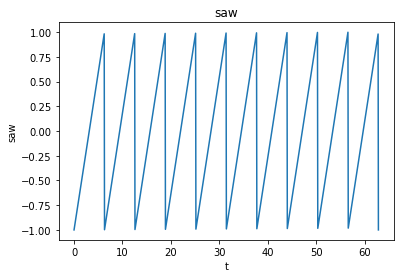

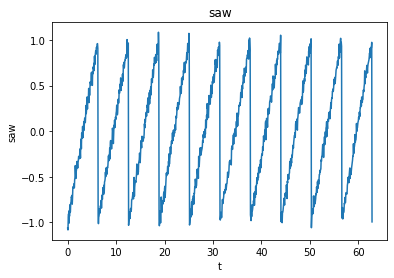

In [ ]:
# add noise
samples = 1000
functype = 'saw'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the network
model = Sequential()
model.add(SimpleRNN(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 2s - loss: 0.0472 - val_loss: 0.0052 - 2s/epoch - 3ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0082 - val_loss: 0.0019 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0076 - val_loss: 0.0022 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0076 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0079 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0077 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0078 - val_loss: 0.0012 - 1s/epoch - 2ms/step



test loss = 0.004541813861578703


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1861
valid MSE: 0.0751
test MSE: 0.1461


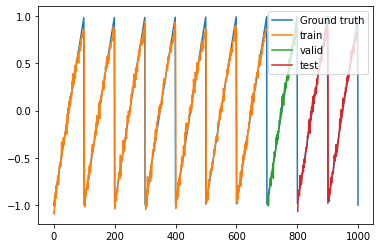

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 552.9355982644704


# LSTM

## sin

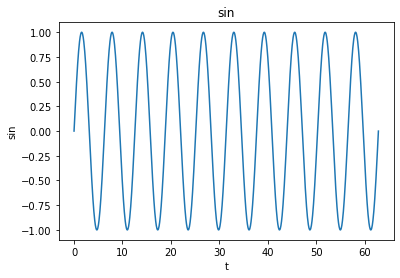

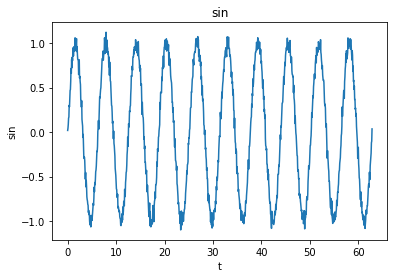

In [ ]:
# add noise
samples = 1000
functype = 'sin'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0605 - val_loss: 0.0106 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 2s - loss: 0.0039 - val_loss: 0.0016 - 2s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0017 - val_loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 2s - loss: 0.0017 - val_loss: 0.0013 - 2s/epoch - 2ms/step



test loss = 0.0013966313563287258


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0875
valid MSE: 0.0809
test MSE: 0.0830


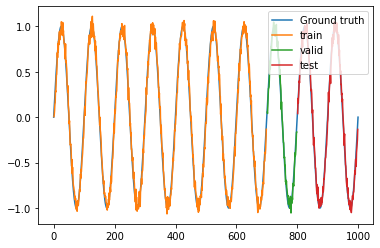

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 537.7191251313174


## tri

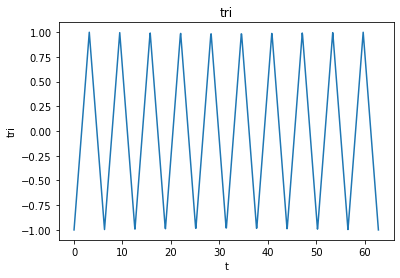

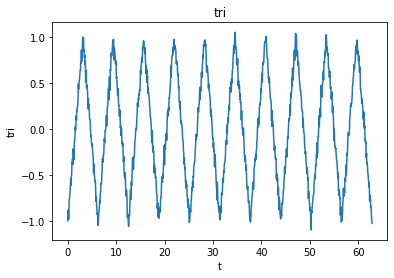

In [ ]:
# add noise
samples = 1000
functype = 'tri'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
689/689 - 4s - loss: 0.0308 - val_loss: 0.0060 - 4s/epoch - 6ms/step
Epoch 2/10
689/689 - 1s - loss: 0.0036 - val_loss: 0.0022 - 1s/epoch - 2ms/step
Epoch 3/10
689/689 - 1s - loss: 0.0015 - val_loss: 0.0014 - 1s/epoch - 2ms/step
Epoch 4/10
689/689 - 1s - loss: 0.0013 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 5/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 6/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 7/10
689/689 - 1s - loss: 0.0012 - val_loss: 0.0016 - 1s/epoch - 2ms/step
Epoch 8/10
689/689 - 1s - loss: 0.0011 - val_loss: 9.7820e-04 - 1s/epoch - 2ms/step
Epoch 9/10
689/689 - 1s - loss: 0.0011 - val_loss: 9.7809e-04 - 1s/epoch - 2ms/step
Epoch 10/10
689/689 - 1s - loss: 0.0011 - val_loss: 0.0011 - 1s/epoch - 2ms/step



test loss = 0.0011479281820356846


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.0708
valid MSE: 0.0718
test MSE: 0.0727


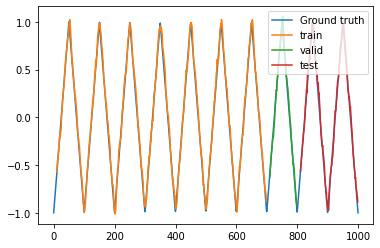

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 641.6999913172956


## saw

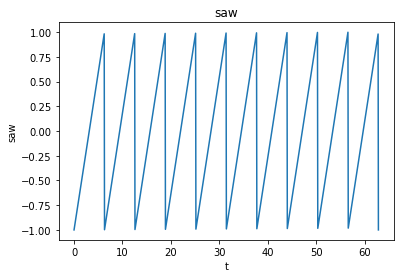

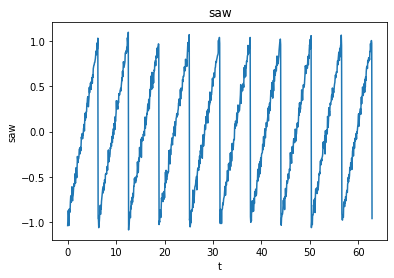

In [ ]:
# add noise
samples = 1000
functype = 'saw'
noise = np.random.normal(0,0.05,samples)
xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, True)
seq_n = seq + noise
plot_signal(xaxis, seq_n, functype)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size
train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]
print('train shape = ', len(train))
print('valid shape = ', len(valid))
print('test shape  = ', len(test))

train shape =  700
valid shape =  100
test shape  =  200


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=2)

print('\n\n')
score = model.evaluate(testX, testY, verbose=0)
print('test loss =', score)

Epoch 1/10
698/698 - 4s - loss: 0.0664 - val_loss: 0.0175 - 4s/epoch - 5ms/step
Epoch 2/10
698/698 - 1s - loss: 0.0155 - val_loss: 0.0041 - 1s/epoch - 2ms/step
Epoch 3/10
698/698 - 1s - loss: 0.0095 - val_loss: 0.0015 - 1s/epoch - 2ms/step
Epoch 4/10
698/698 - 1s - loss: 0.0087 - val_loss: 0.0047 - 1s/epoch - 2ms/step
Epoch 5/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 6/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0023 - 1s/epoch - 2ms/step
Epoch 7/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0012 - 1s/epoch - 2ms/step
Epoch 8/10
698/698 - 1s - loss: 0.0088 - val_loss: 0.0013 - 1s/epoch - 2ms/step
Epoch 9/10
698/698 - 1s - loss: 0.0087 - val_loss: 0.0011 - 1s/epoch - 2ms/step
Epoch 10/10
698/698 - 1s - loss: 0.0086 - val_loss: 0.0011 - 1s/epoch - 2ms/step



test loss = 0.004613384138792753


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('train MSE: {:.4f}'.format(trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('valid MSE: {:.4f}'.format(validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('test MSE: {:.4f}'.format(testScore))

train MSE: 0.1988
valid MSE: 0.0705
test MSE: 0.1477


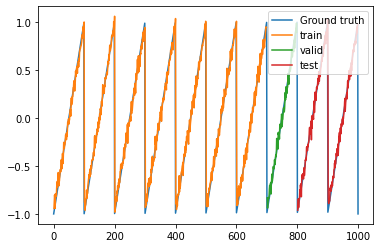

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift valid predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(seq, label='Ground truth')
plt.plot(trainPredictPlot, label='train')
plt.plot(validPredictPlot, label='valid')
plt.plot(testPredictPlot, label='test')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('SNR =', snr_f(seq_n, noise, 2*np.pi))

SNR = 1932.3187060644009


# Effect of some hyperparameters on signal

## Variance 

mu =  0.05


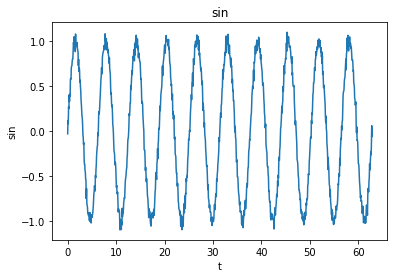

test loss = 0.000936469528824091 

train MSE: 0.0657
valid MSE: 0.0651
test MSE: 0.0674 



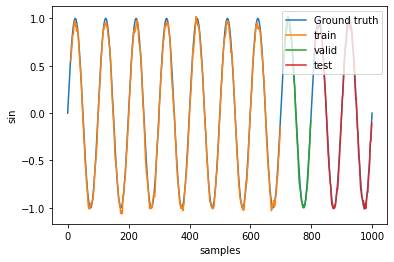

mu =  0.1


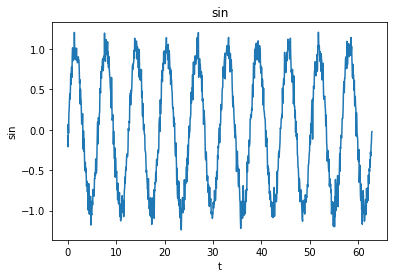

test loss = 0.0029282551258802414 

train MSE: 0.1183
valid MSE: 0.1087
test MSE: 0.1323 



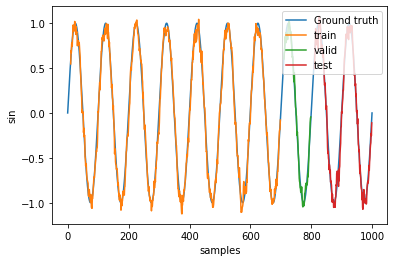

mu =  0.2


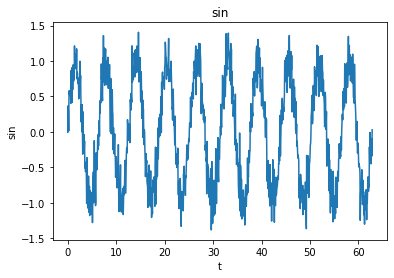

test loss = 0.006826096214354038 

train MSE: 0.2366
valid MSE: 0.2412
test MSE: 0.2304 



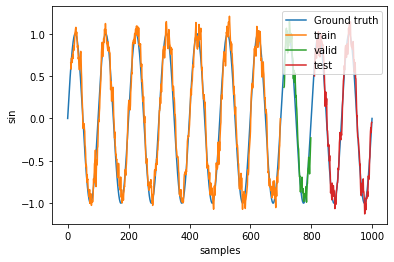

mu =  0.3


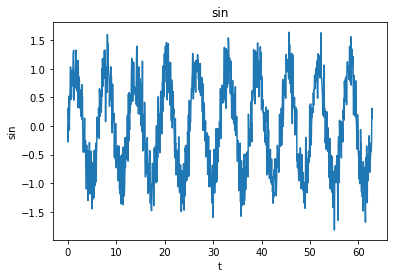

test loss = 0.010113395750522614 

train MSE: 0.3415
valid MSE: 0.3208
test MSE: 0.3469 



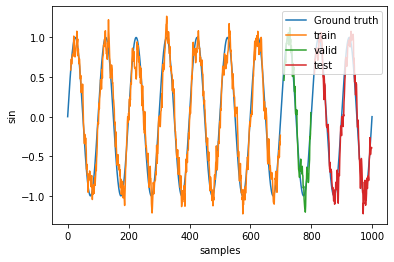

mu =  0.5


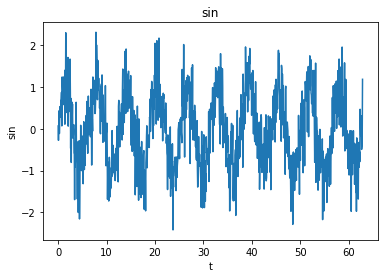

test loss = 0.015178567729890347 

train MSE: 0.5794
valid MSE: 0.5816
test MSE: 0.5831 



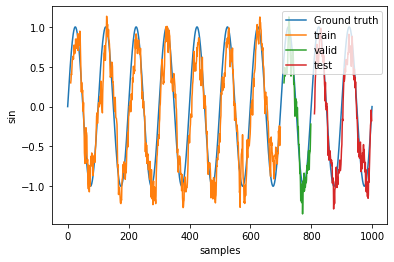

In [ ]:
samples = 1000
functype = 'sin'

for mu in [0.05, 0.1, 0.2, 0.3, 0.5]:
  print('====================================================================')
  print('mu = ', mu)
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 10
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

## Learning rate

LR =  0.001


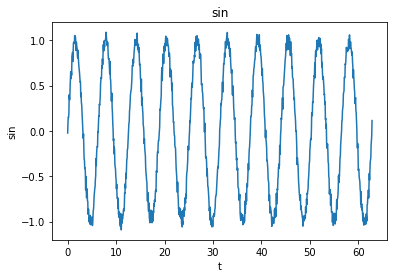

test loss = 0.0016590168233960867 

train MSE: 0.0860
valid MSE: 0.0849
test MSE: 0.0888 



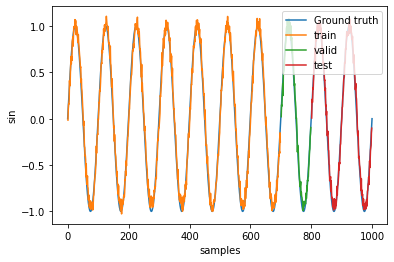

LR =  0.01


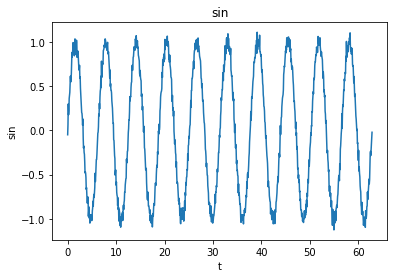

test loss = 0.002317448379471898 

train MSE: 0.1040
valid MSE: 0.0999
test MSE: 0.1075 



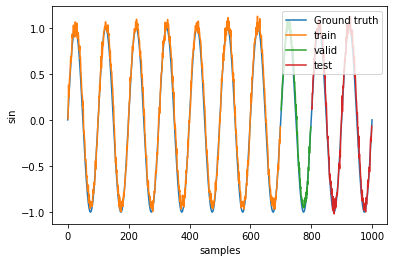

LR =  0.1


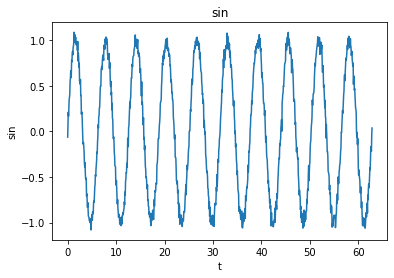

test loss = 0.0067498995922505856 

train MSE: 0.1766
valid MSE: 0.1805
test MSE: 0.1782 



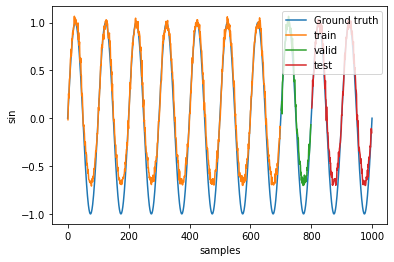

LR =  0.2


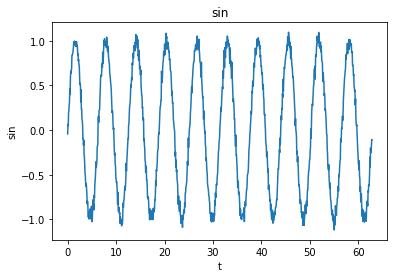

test loss = 0.020542632788419724 

train MSE: 0.3174
valid MSE: 0.3142
test MSE: 0.3176 



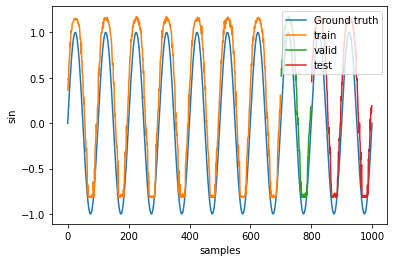

In [ ]:
for LR in [0.001, 0.01, 0.1, 0.2]:
  print('====================================================================')
  print('LR = ', LR)
  mu = 0.05
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=LR)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

## Batch size

batch size =  1


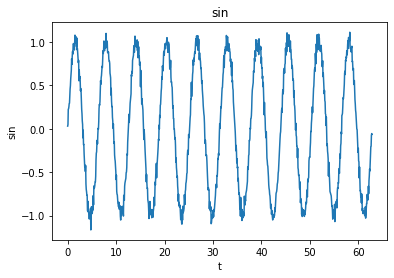

test loss = 0.0014782153302803636 

train MSE: 0.0863
valid MSE: 0.0942
test MSE: 0.0876 



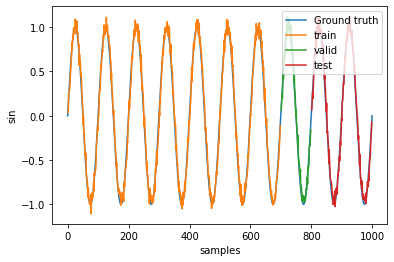

batch size =  10


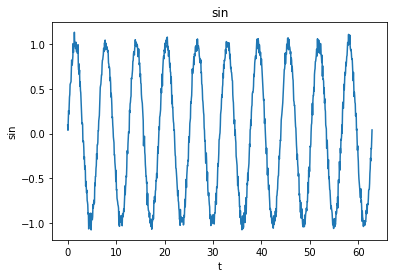

test loss = 0.002791646169498563 

train MSE: 0.1116
valid MSE: 0.1133
test MSE: 0.1165 



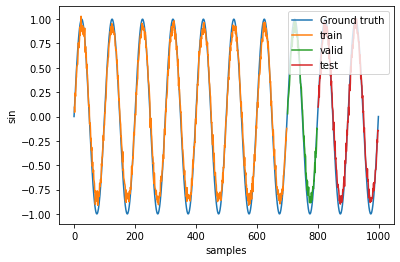

batch size =  30


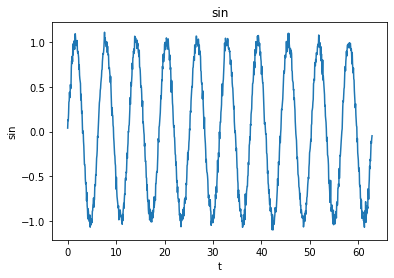

test loss = 0.039389245212078094 

train MSE: 0.4402
valid MSE: 0.4395
test MSE: 0.4387 



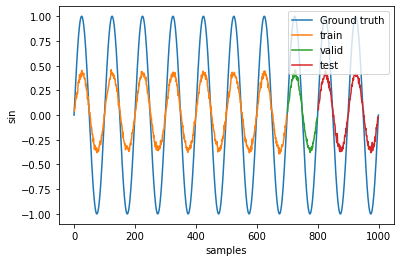

batch size =  50


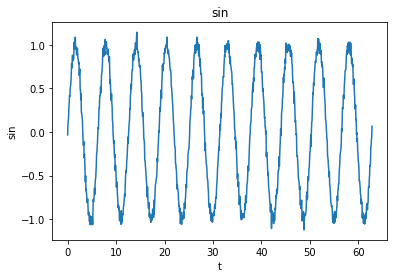

test loss = 0.059338320046663284 

train MSE: 0.5501
valid MSE: 0.5585
test MSE: 0.5519 



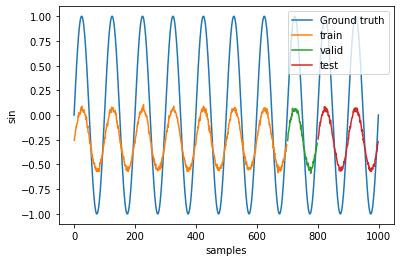

batch size =  100


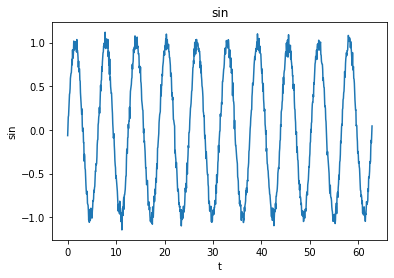

test loss = 0.15922638773918152 

train MSE: 0.9017
valid MSE: 0.9071
test MSE: 0.9042 



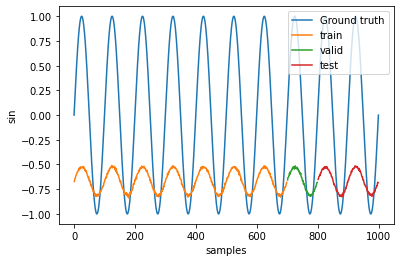

In [ ]:
for batch_size in [1, 10, 30, 50, 100]:
  print('====================================================================')
  print('batch size = ', batch_size)
  mu = 0.05
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=batch_size, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()

## Number of epochs

epoch =  1


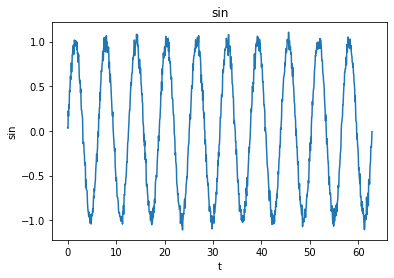

test loss = 0.014593610540032387 

train MSE: 0.2667
valid MSE: 0.2669
test MSE: 0.2674 



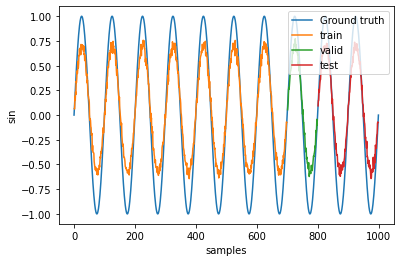

epoch =  5


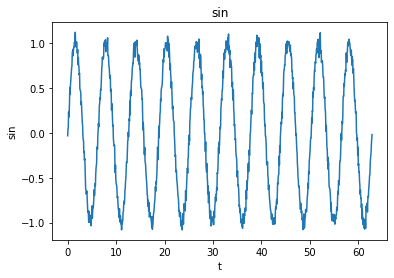

test loss = 0.0014935166109353304 

train MSE: 0.0876
valid MSE: 0.0772
test MSE: 0.0852 



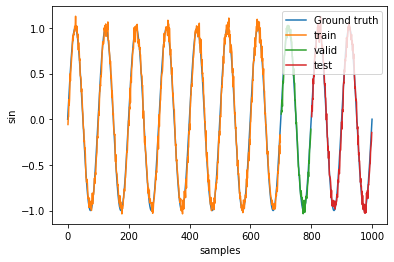

epoch =  10


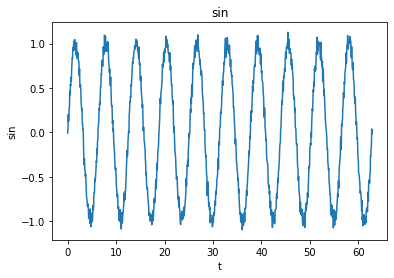

test loss = 0.001802915590815246 

train MSE: 0.0849
valid MSE: 0.0865
test MSE: 0.0945 



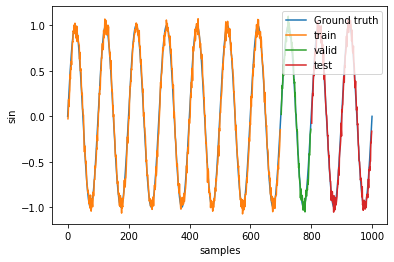

epoch =  20


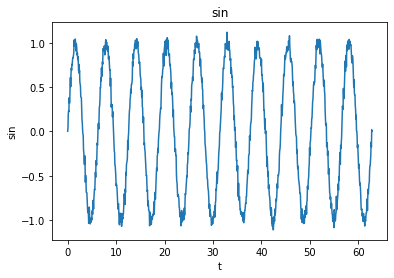

test loss = 0.0015026602195575833 

train MSE: 0.0822
valid MSE: 0.0786
test MSE: 0.0865 



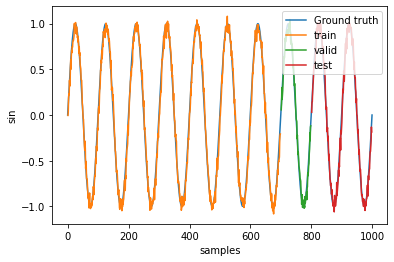

epoch =  30


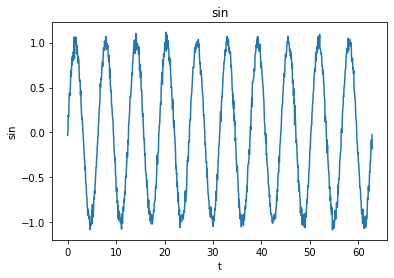

test loss = 0.0014618284767493606 

train MSE: 0.0859
valid MSE: 0.0910
test MSE: 0.0841 



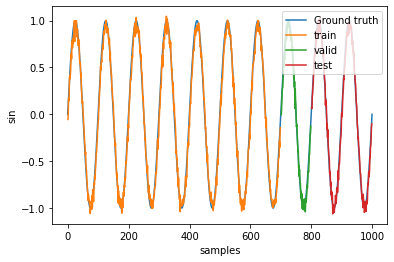

In [ ]:
for epoch in [1, 5, 10, 20, 30]:
  print('====================================================================')
  print('epoch = ', epoch)
  mu = 0.05
  noise = np.random.normal(0,mu,samples)
  xaxis, seq = ocilator_gen(functype, 10, 2*np.pi, 0, samples, False)
  seq_n = seq + noise
  plot_signal(xaxis, seq_n, functype)
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(seq_n.reshape(-1,1)).reshape(-1,1)

  # split into train and test sets
  train_size = int(len(dataset) * 0.7)
  valid_size = int(len(dataset) * 0.1)
  test_size = len(dataset) - train_size - valid_size
  train, valid, test = dataset[0:train_size,:], dataset[train_size:train_size+valid_size,:], dataset[train_size+valid_size:len(dataset),:]

  # reshape into X=t and Y=t+1
  look_back = 1
  trainX, trainY = create_dataset(train, look_back)
  validX, validY = create_dataset(valid, look_back)
  testX, testY = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(10, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, validation_data=(validX, validY), epochs=epoch, batch_size=1, verbose=0)

  score = model.evaluate(testX, testY, verbose=0)
  print('test loss =', score, '\n')

  # make predictions
  trainPredict = model.predict(trainX)
  validPredict = model.predict(validX)
  testPredict = model.predict(testX)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])
  validPredict = scaler.inverse_transform(validPredict)
  validY = scaler.inverse_transform([validY])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([testY])
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
  print('train MSE: {:.4f}'.format(trainScore))
  validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
  print('valid MSE: {:.4f}'.format(validScore))
  testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
  print('test MSE: {:.4f} \n'.format(testScore))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift valid predictions for plotting
  validPredictPlot = np.empty_like(dataset)
  validPredictPlot[:, :] = np.nan
  validPredictPlot[len(trainPredict)+(look_back*2)+1:len(trainPredict)+(look_back*2)+1+len(validPredict), :] = validPredict
  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+len(validPredict)+(look_back*3)+2:len(dataset)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(seq, label='Ground truth')
  plt.plot(trainPredictPlot, label='train')
  plt.plot(validPredictPlot, label='valid')
  plt.plot(testPredictPlot, label='test')
  plt.xlabel('samples')
  plt.ylabel('sin')
  plt.legend(loc='upper right')
  plt.show()